In [66]:
import pandas as pd
from pymongo import MongoClient
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta

cf.set_config_file(theme='ggplot', sharing='public', offline=True)
plotly.io.renderers.default= 'png'


def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db='OpenRoadDB_20211126')

KPI = db.kpi
ENGINE = db.engine
ENGINE_HISTORY = db.engine_history


run_id_meta = {
    'Qe6zrnP9LGue': 'Pickup Optimal',
    'EYbRXy2QvS9X': 'Revenue Optimal',
    'xTEFl5shuFn5': 'Service Optimal',
    # '4fzh7Q52k4af': 'Compromise 0',
    'rI4ODMzcmnXi': 'Compromise',
} # Comfort Data Set Sampled (10p 8d)



In [67]:
# cursor = db.engine_history.find({
#             'run_id': 'xSx0cwH3JgTH',
#         },
#         projection={ '_id': 0, 'online_params.realtime_reverse_pickup_time_step': 1},
#         sort=[('online_params.realtime_reverse_pickup_time_step', -1)]
#     )

# list(cursor)

In [68]:
def get_pivot(collection, run_id_meta, metric):
    cursor = collection.find({
            'run_id': {'$in': [k for k, _ in run_id_meta.items()]},
            'metric': metric
        },
        projection={ '_id': 0, 'run_id': 1, 'sim_clock': 1, 'value': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))

    metric_pivot = pd.pivot_table(metric_df, 
                                  index='sim_clock', 
                                  columns='run_id', 
                                  values='value').rename(columns=run_id_meta)
    cumulative_pivot = metric_pivot.cumsum()

    return metric_pivot, cumulative_pivot



def get_engine_perf(collection, run_id_list):
    cursor = collection.find({
            'run_id': {'$in': run_id_list},
        },
        projection={ '_id': 0, 'online_params': 1, 'sim_clock': 1, 'runtime_performance': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))
    metric_df = pd.concat([metric_df.drop(['online_params'], axis=1), metric_df['online_params'].apply(pd.Series)], axis=1)
    metric_df = pd.concat([metric_df.drop(['runtime_performance'], axis=1), metric_df['runtime_performance'].apply(pd.Series)], axis=1)

    metric_df

    return metric_df



sum_metric = [
    'num_served_step', 
    'num_cancelled_step',
    'revenue_step', 
    'wait_time_pickup_step',
    'service_score_step'
]
avg_metric_byServed = [
    'revenue_step', 
    'wait_time_pickup_step',
    # 'wait_time_driver_confirm', 
    # 'wait_time_assignment',
    'service_score_step'
]



In [69]:

gamma = 1.2
# Sum(Revenue) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_revenue Scenario
target_revenue = 35166.72 * gamma / 960 / 1
print(f"{target_revenue=}")


# Sum(pickup_budget) - Sum(pickup_time) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_pickup Scenario
# Budget Computed by max Pickup (600) * Num_Served 
target_pickup_time = ((600*2448) - (958890.0)) * gamma / 960 / 10
print(f"{target_pickup_time=}")

# Sum(service_score) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_service Scenario
target_service = 181065.0 * 1 / 960 / 5
print(f"{target_service=}")



target_revenue=43.9584
target_pickup_time=63.73875
target_service=37.721875


In [70]:
# cursor = KPI.find({
#         'run_id': {'$in': [k for k, _ in run_id_meta.items()]},
#     },
#     projection={ '_id': 0, 'run_id': 1, 'sim_clock': 1, 'value': 1, 'metric': 1,},
#     sort=[('sim_clock', 1)]
# )

# metric_df = pd.DataFrame(list(cursor))



run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30        2252.0           1525.0          2448.0   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30      2357.0           2066.0  


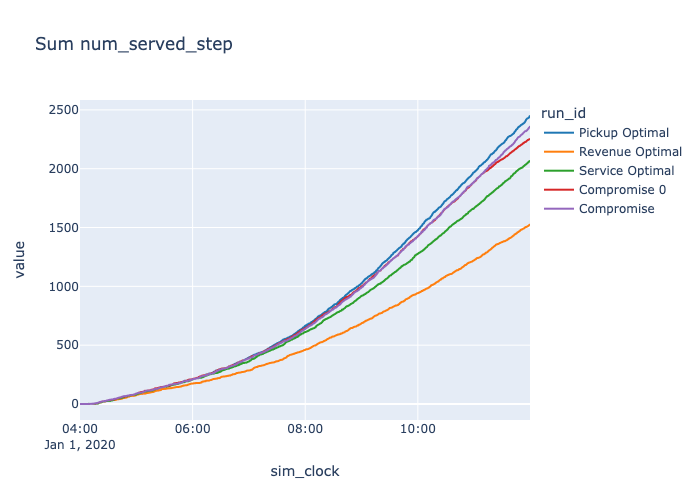

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30        4577.0           5305.0          4391.0   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30      4486.0           4741.0  


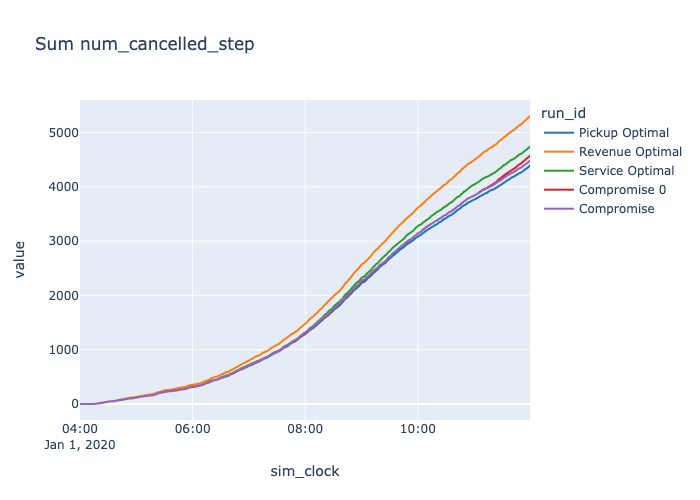

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30      35257.86         35166.72        33793.61   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30    34430.45         29518.98  


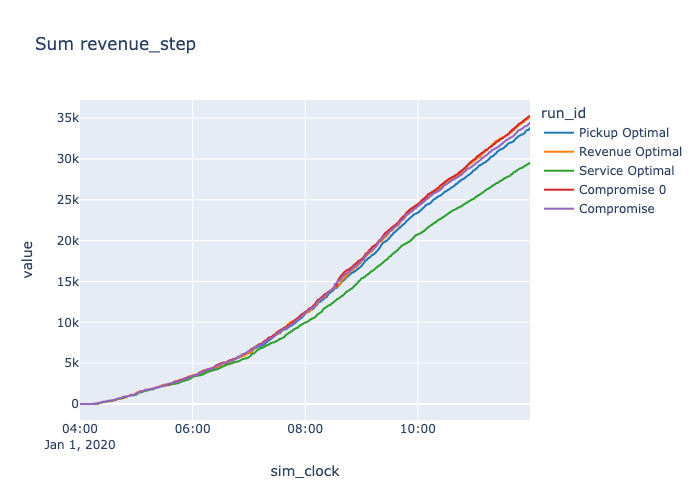

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30      895470.0         855720.0        958890.0   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30    929220.0        1139250.0  


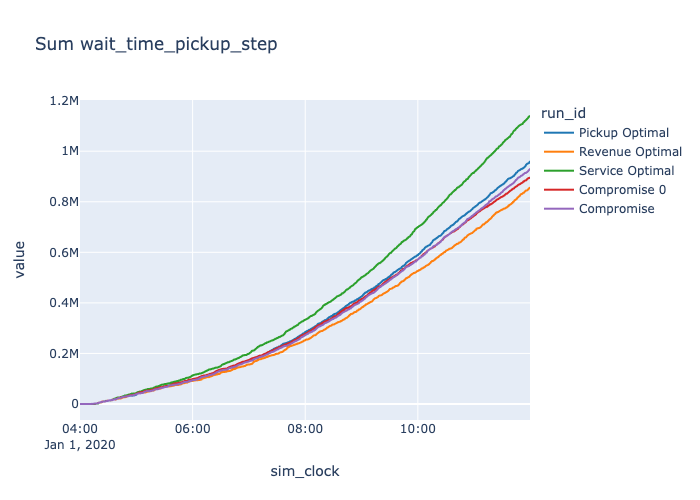

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30      166993.0         112391.0        181065.0   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30    174528.0         152762.0  


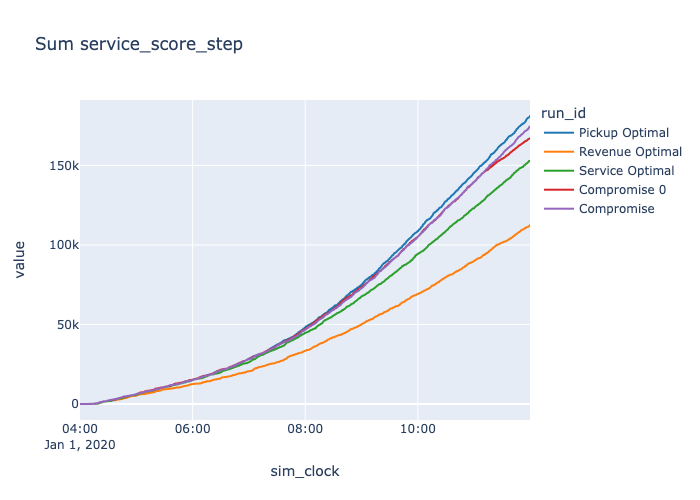

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30     15.656243        23.060144       13.804579   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30   14.607743        14.287986  


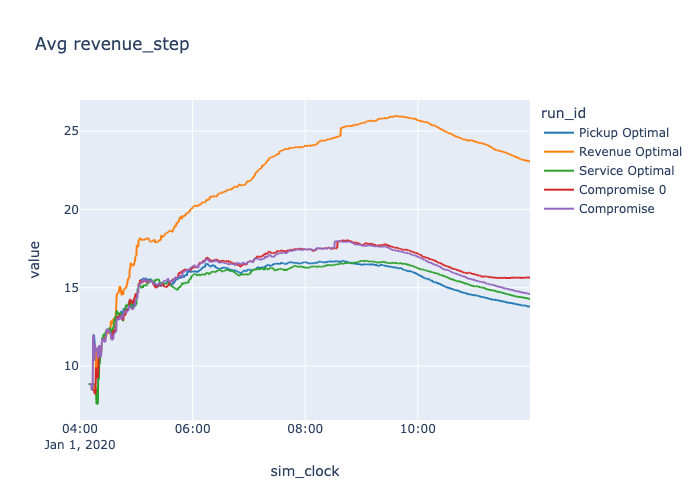

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30    397.633215       561.127869      391.703431   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30  394.238439        551.42788  


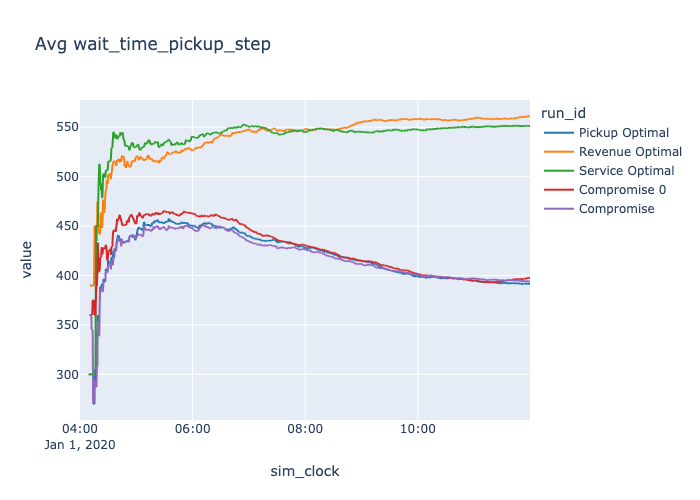

run_id               Compromise 0  Revenue Optimal  Pickup Optimal  \
sim_clock                                                            
2020-01-01 11:59:30     74.153197        73.699016       73.964461   

run_id               Compromise  Service Optimal  
sim_clock                                         
2020-01-01 11:59:30   74.046669        73.940949  


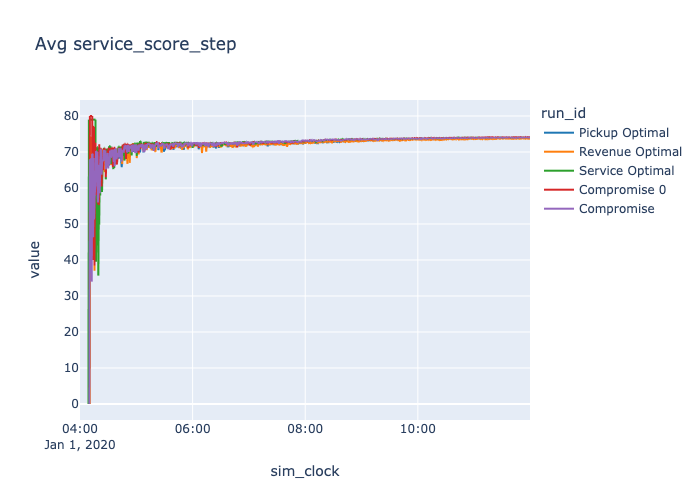

In [83]:
from IPython.display import Image

for m in sum_metric:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    print(cum_pivot.tail(1))

    fig = px.line(cum_pivot, title=f"Sum {m}",
                 color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 
    fig.show()


served_pivot, cum_served_pivot = get_pivot(KPI, run_id_meta, 'num_served_step')
for m in avg_metric_byServed:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    metric_pivot = metric_pivot / served_pivot
    cum_pivot = cum_pivot / cum_served_pivot
    print(cum_pivot.tail(1))

    fig = px.line(cum_pivot, title=f"Avg {m}",
                 color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 
    fig.show()



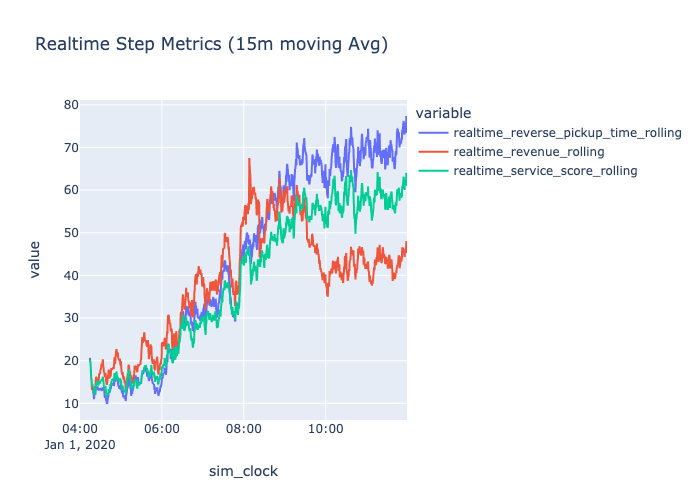

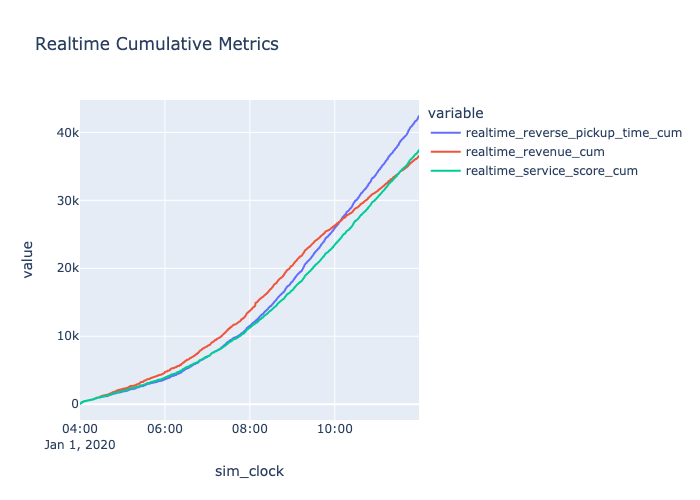

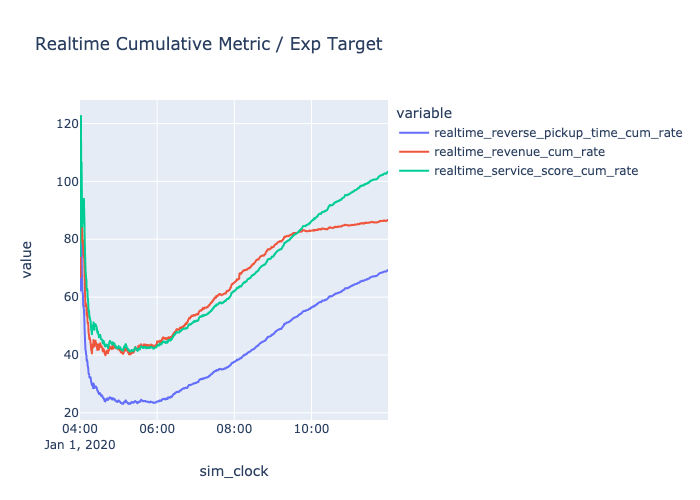

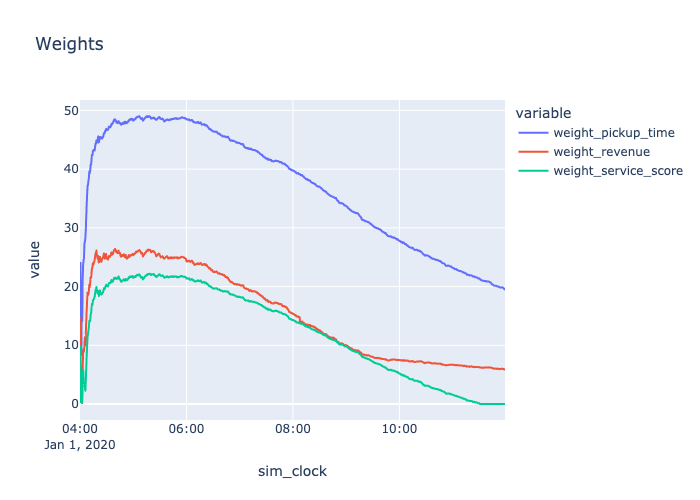

In [84]:
# engine_df = get_engine_perf(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Pickup Optimal'])
# engine_df = get_engine_perf(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Revenue Optimal'])
# engine_df = get_engine_perf(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Service Optimal'])
engine_df = get_engine_perf(ENGINE_HISTORY, [k for k, v in run_id_meta.items() if v == 'Compromise'])




engine_df['realtime_reverse_pickup_time_cum_rate'] = 100* engine_df['realtime_reverse_pickup_time_cum'] / engine_df['exp_target_reverse_pickup_time']
engine_df['realtime_revenue_cum_rate'] = 100* engine_df['realtime_revenue_cum'] / engine_df['exp_target_revenue']
engine_df['realtime_service_score_cum_rate'] = 100* engine_df['realtime_service_score_cum'] / engine_df['exp_target_service_score']

engine_df[['realtime_reverse_pickup_time_rolling',
         'realtime_revenue_rolling', 
         'realtime_service_score_rolling']] = engine_df[['realtime_reverse_pickup_time_step',
                                                 'realtime_revenue_step', 
                                                 'realtime_service_score_step']].rolling(30).mean()
# fig = px.line(engine_df, x='sim_clock', 
#               y=['realtime_reverse_pickup_time_rate','realtime_revenue_rate', 'realtime_service_score_rate',
#                 ],
#               title='Compromise') #, labels = run_id_meta)
# fig.show()
fig = px.line(engine_df, 
              x='sim_clock', 
              y=['realtime_reverse_pickup_time_rolling',
                 'realtime_revenue_rolling', 
                 'realtime_service_score_rolling',
                ],
              title='Realtime Step Metrics (15m moving Avg)') #, labels = run_id_meta)
fig.show()

fig = px.line(engine_df, x='sim_clock', 
              y=['realtime_reverse_pickup_time_cum',
                 'realtime_revenue_cum',
                 'realtime_service_score_cum',
                ],
              title='Realtime Cumulative Metrics') #, labels = run_id_meta)
fig.show()

fig = px.line(engine_df, x='sim_clock', 
              y=['realtime_reverse_pickup_time_cum_rate',
                 'realtime_revenue_cum_rate', 
                 'realtime_service_score_cum_rate',
                ],
              title='Realtime Cumulative Metric / Exp Target') #, labels = run_id_meta)
fig.show()

fig = px.line(engine_df, x='sim_clock', 
              y=['weight_pickup_time',
                 'weight_revenue', 
                 'weight_service_score',
                ],
              title='Weights') #, labels = run_id_meta)
fig.show()





In [ ]:
# engine_df.tail(100)